In [520]:
import requests
from bs4 import BeautifulSoup
from transformers import pipeline
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import feedparser
import requests
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import LabelEncoder  
from sklearn.ensemble import RandomForestClassifier  
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  
  
  

In [6]:
finbert = pipeline("sentiment-analysis", model="ProsusAI/finbert")

Device set to use cpu


In [529]:
def get_yahoo_finance_urls_selenium(ticker, max_scrolls=1):

    driver = webdriver.Chrome()  
    base_url = f"https://finance.yahoo.com/quote/{ticker}/news"
    driver.get(base_url)
    wait = WebDriverWait(driver, 10)

    article_urls = set()

    try:
        for scroll in range(max_scrolls):

            wait.until(EC.presence_of_all_elements_located((By.TAG_NAME, "a")))

            articles = driver.find_elements(By.TAG_NAME, "a")
            for article in articles:
                href = article.get_attribute("href")
                if ("finance.yahoo.com/news" in href) and ("pple" in href) and ('html' in href):
                    article_urls.add(href)


            ActionChains(driver).scroll_by_amount(0, 1000).perform()
            time.sleep(2) 

            print(f"Scroll {scroll + 1}: Collected {len(article_urls)} URLs so far.")

    except Exception as e:
        print(f"Error while scrolling: {e}")

    finally:
        driver.quit()

    return list(article_urls)

In [523]:
def scrape_article_content(url):
    try:
        response = requests.get(url)
        soup = BeautifulSoup(response.content, "html.parser")
        paragraphs = soup.find_all("p")
        article_content = " ".join([para.get_text() for para in paragraphs])
        return article_content
    except Exception as e:
        print(f"Error scraping {url}: {e}")
        return ""

In [524]:
def get_sentiment_score(text):
    result = finbert(text)[0]
    label = result['label']
    score = result['score'] if label != "NEUTRAL" else 0
    return label, score

In [525]:
def split_text_into_word_chunks(text, chunk_size=511):


    words = text.split()

    chunks = [" ".join(words[i:i + chunk_size]) for i in range(0, len(words), chunk_size)]
    
    return chunks

In [521]:
def scrape_article_headline_and_date(url):  

   headers = {  
      "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"  
   }  
  
   response = requests.get(url, headers=headers)  
   soup = BeautifulSoup(response.text, "html.parser")
    
   headline = soup.find("title").text.strip()  

   headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
   }

   response = requests.get(url, headers=headers)
   if response.status_code != 200:
       raise Exception(f"Failed to fetch the URL. Status code: {response.status_code}")

   soup = BeautifulSoup(response.text, 'html.parser')

   date_element = soup.find("time")
   if date_element and "datetime" in date_element.attrs:
       date = date_element["datetime"]
   else:
       date = "Date not found"
    
   return {  
      "headline": headline,  
      "date": date  
   }  

In [328]:
def initialize_sentiment_scores(segments):
    scores = {"positive": 0, "neutral": 0, "negative": 0}
    total_segments = len(segments)

    for segment in segments:
        try:
            label, score = get_sentiment_score(segment)
            scores[label.lower()] += score
        except Exception as e:
            print(f"Error processing segment: {e}")


    overall_scores = {key: value / total_segments for key, value in scores.items()}


    overall_label = max(overall_scores, key=overall_scores.get)

    return overall_label, overall_scores

In [329]:
def calculate_overall_sentiment(text, headline):

    segments = split_text_into_word_chunks(text, chunk_size=300)
    text_label, text_score = initialize_sentiment_scores(segments)
    headline_label, headline_score = initialize_sentiment_scores(headline)
    segments.append(headline)  
    overall_label, overall_scores = initialize_sentiment_scores(segments)
    
    
    return {
        "text_label": text_label,
        "text_score": text_score,
        "headline_label": headline_label,
        "headline_score": headline_score,
        "overall_label": overall_label,
        "overall_scores": overall_scores
    }

In [330]:
def scrape_article_and_headline_return_scores(url,printer):
    scraped_article_raw = scrape_article_content(url)
    
    articles_data = {}
    scraped_headline_and_date_raw = scrape_article_headline_and_date(url)
    headline_raw = scraped_headline_and_date_raw["headline"]
    date_raw = scraped_headline_and_date_raw["date"]
    

    results = calculate_overall_sentiment(scraped_article_raw, headline_raw)
    clean_date = datetime.strptime(date_raw, "%Y-%m-%dT%H:%M:%S.%fZ")

    formatted_date = clean_date.strftime("%Y-%m-%d %H:%M:%S")
    
    if printer == 1:
        print("Headline: " + headline_raw)
        print("Date: " + formatted_date)
        print("URL: " + url)
        print("Text Scores:", results["text_score"])
        print("Text Sentiment Label:", results["text_label"])
        print("Headline Scores:", results["headline_score"])
        print("Headline Sentiment Label:", results["headline_label"])
        print("Overall Scores:", results["overall_scores"])
        print("Overall Sentiment Label:", results["overall_label"])
        print("-" * 50)
    
    articles_data[url] = {
            "headline": headline_raw,
            "Date": formatted_date,
            "text_scores": results['text_score'],
            "text_sentiment_label": results['text_label'],
            "headline_scores": results['headline_score'],
            "headline_sentiment_label": results['headline_label'],
            "overall_scores": results['overall_scores'],
            "overall_sentiment_label": results['overall_label']
        }
    
    
    return articles_data

In [331]:
url = 'https://finance.yahoo.com/news/incredibly-cheap-artificial-intelligence-ai-082000557.html'
scrape_article_and_headline_return_scores(url,1)

Headline: Will This Incredibly Cheap Artificial Intelligence (AI) Stock Soar in 2025?
Date: 2024-12-21 08:20:00
URL: https://finance.yahoo.com/news/incredibly-cheap-artificial-intelligence-ai-082000557.html
Text Scores: {'positive': 0.15319056312243143, 'neutral': 0.3108155429363251, 'negative': 0.4682427644729614}
Text Sentiment Label: negative
Headline Scores: {'positive': 0.0, 'neutral': 0.825523920059204, 'negative': 0.0}
Headline Sentiment Label: neutral
Overall Scores: {'positive': 0.1313061969620841, 'neutral': 0.39249864646366667, 'negative': 0.40135094097682406}
Overall Sentiment Label: negative
--------------------------------------------------


{'https://finance.yahoo.com/news/incredibly-cheap-artificial-intelligence-ai-082000557.html': {'headline': 'Will This Incredibly Cheap Artificial Intelligence (AI) Stock Soar in 2025?',
  'Date': '2024-12-21 08:20:00',
  'text_scores': {'positive': 0.15319056312243143,
   'neutral': 0.3108155429363251,
   'negative': 0.4682427644729614},
  'text_sentiment_label': 'negative',
  'headline_scores': {'positive': 0.0,
   'neutral': 0.825523920059204,
   'negative': 0.0},
  'headline_sentiment_label': 'neutral',
  'overall_scores': {'positive': 0.1313061969620841,
   'neutral': 0.39249864646366667,
   'negative': 0.40135094097682406},
  'overall_sentiment_label': 'negative'}}

In [526]:
def scrape_yahoo(ticker):
    article_urls = get_yahoo_finance_urls_selenium(ticker)
    articles_data = {}
    
    for url in article_urls:
        results = scrape_article_and_headline_return_scores(url, 1)
        articles_data = articles_data | results

    return articles_data

In [334]:
#this takes roughly 5 minutes, present data is available below
real_articles_data = {}
real_articles_data = scrape_yahoo('AAPL')

Scroll 1: Collected 6 URLs so far.
Scroll 2: Collected 6 URLs so far.
Scroll 3: Collected 6 URLs so far.
Scroll 4: Collected 6 URLs so far.
Scroll 5: Collected 17 URLs so far.
Scroll 6: Collected 17 URLs so far.
Scroll 7: Collected 17 URLs so far.
Scroll 8: Collected 24 URLs so far.
Scroll 9: Collected 24 URLs so far.
Scroll 10: Collected 24 URLs so far.
Scroll 11: Collected 34 URLs so far.
Scroll 12: Collected 34 URLs so far.
Scroll 13: Collected 34 URLs so far.
Scroll 14: Collected 34 URLs so far.
Scroll 15: Collected 34 URLs so far.
Scroll 16: Collected 34 URLs so far.
Scroll 17: Collected 34 URLs so far.
Scroll 18: Collected 34 URLs so far.
Scroll 19: Collected 34 URLs so far.
Scroll 20: Collected 34 URLs so far.
Headline: European Commission Seeks Feedback on Apple Interoperability Measures
Date: 2024-12-19 15:12:47
URL: https://finance.yahoo.com/news/european-commission-seeks-feedback-apple-151247119.html
Text Scores: {'positive': 0.0, 'neutral': 0.8932265043258667, 'negative': 0

In [337]:
preset_data = {'https://finance.yahoo.com/news/european-commission-seeks-feedback-apple-151247119.html': {'headline': 'European Commission Seeks Feedback on Apple Interoperability Measures', 'Date': '2024-12-19 15:12:47', 'text_scores': {'positive': 0.0, 'neutral': 0.8932265043258667, 'negative': 0.0}, 'text_sentiment_label': 'neutral', 'headline_scores': {'positive': 0.0, 'neutral': 0.8409809107365815, 'negative': 0.0}, 'headline_sentiment_label': 'neutral', 'overall_scores': {'positive': 0.0, 'neutral': 0.8581481873989105, 'negative': 0.0}, 'overall_sentiment_label': 'neutral'}, 'https://finance.yahoo.com/news/semiconductor-set-capitalize-growth-apple-140544912.html': {'headline': 'BE Semiconductor Set to Capitalize on Growth from Apple and Nvidia Innovations', 'Date': '2024-12-23 14:05:44', 'text_scores': {'positive': 0.0, 'neutral': 0.4060947000980377, 'negative': 0.2344380021095276}, 'text_sentiment_label': 'neutral', 'headline_scores': {'positive': 0.0, 'neutral': 0.8208804420935802, 'negative': 0.0}, 'headline_sentiment_label': 'neutral', 'overall_scores': {'positive': 0.2924375931421916, 'neutral': 0.27072980006535846, 'negative': 0.15629200140635172}, 'overall_sentiment_label': 'positive'}, 'https://finance.yahoo.com/news/latest-survey-shows-apple-aapl-103713079.html': {'headline': 'Latest Survey Shows Apple (AAPL) iPhone 16 Market Share, Momentum Lower Year Over Year', 'Date': '2024-12-24 10:37:13', 'text_scores': {'positive': 0.2720382610956828, 'neutral': 0.2934728264808655, 'negative': 0.318117360273997}, 'text_sentiment_label': 'negative', 'headline_scores': {'positive': 0.0, 'neutral': 0.8198309720948685, 'negative': 0.0}, 'headline_sentiment_label': 'neutral', 'overall_scores': {'positive': 0.20402869582176208, 'neutral': 0.2201046198606491, 'negative': 0.4791157841682434}, 'overall_sentiment_label': 'negative'}, 'https://finance.yahoo.com/news/apple-complains-meta-requests-risk-141541687.html': {'headline': 'Apple complains Meta requests risk privacy in spat over EU efforts to widen access to iPhone tech', 'Date': '2024-12-19 14:15:41', 'text_scores': {'positive': 0.0, 'neutral': 0.4570048451423645, 'negative': 0.3314244747161865}, 'text_sentiment_label': 'neutral', 'headline_scores': {'positive': 0.0, 'neutral': 0.8106126170797446, 'negative': 0.0}, 'headline_sentiment_label': 'neutral', 'overall_scores': {'positive': 0.0, 'neutral': 0.30466989676157635, 'negative': 0.5344709157943726}, 'overall_sentiment_label': 'negative'}, 'https://finance.yahoo.com/news/calculating-intrinsic-value-apple-inc-120015021.html': {'headline': 'Calculating The Intrinsic Value Of Apple Inc. (NASDAQ:AAPL)', 'Date': '2024-12-23 12:00:15', 'text_scores': {'positive': 0.0, 'neutral': 0.723262369632721, 'negative': 0.0}, 'text_sentiment_label': 'neutral', 'headline_scores': {'positive': 0.0, 'neutral': 0.8303556836257546, 'negative': 0.0}, 'headline_sentiment_label': 'neutral', 'overall_scores': {'positive': 0.0, 'neutral': 0.7596718668937683, 'negative': 0.0}, 'overall_sentiment_label': 'neutral'}, 'https://finance.yahoo.com/news/why-apple-aapl-ai-push-152142144.html': {'headline': 'Why Apple’s (AAPL) AI Push Could Be the Key to Dominating the Market?', 'Date': '2024-12-22 15:21:42', 'text_scores': {'positive': 0.0, 'neutral': 0.7055338422457377, 'negative': 0.0}, 'text_sentiment_label': 'neutral', 'headline_scores': {'positive': 0.0, 'neutral': 0.804322260013525, 'negative': 0.0}, 'headline_sentiment_label': 'neutral', 'overall_scores': {'positive': 0.0, 'neutral': 0.758070170879364, 'negative': 0.0}, 'overall_sentiment_label': 'neutral'}, 'https://finance.yahoo.com/news/jim-cramer-apple-inc-aapl-103117727.html': {'headline': 'Jim Cramer on Apple Inc. (AAPL): ‘I Say Own It Don’t Trade It. . . It’s So Far The Biggest Position In Our Trust’', 'Date': '2024-12-21 10:31:17', 'text_scores': {'positive': 0.0974031388759613, 'neutral': 0.4630826363960902, 'negative': 0.160312682390213}, 'text_sentiment_label': 'neutral', 'headline_scores': {'positive': 0.0, 'neutral': 0.7920130849939532, 'negative': 0.0}, 'headline_sentiment_label': 'neutral', 'overall_scores': {'positive': 0.08348840475082397, 'neutral': 0.5096781807286399, 'negative': 0.1374108706201826}, 'overall_sentiment_label': 'neutral'}, 'https://finance.yahoo.com/news/apple-finally-added-chatgpt-to-the-iphone-theres-no-guarantee-itll-boost-sales-153635743.html': {'headline': "Apple finally added ChatGPT to the iPhone. There's no guarantee it’ll boost sales.", 'Date': '2024-12-19 15:45:24', 'text_scores': {'positive': 0.0, 'neutral': 0.8906152248382568, 'negative': 0.0}, 'text_sentiment_label': 'neutral', 'headline_scores': {'positive': 0.0, 'neutral': 0.8182608172660921, 'negative': 0.0}, 'headline_sentiment_label': 'neutral', 'overall_scores': {'positive': 0.18323733806610107, 'neutral': 0.7124921798706054, 'negative': 0.0}, 'overall_sentiment_label': 'neutral'}, 'https://finance.yahoo.com/news/apple-discontinues-iphone-subscription-amidst-132513971.html': {'headline': 'Apple Discontinues iPhone Subscription Service Amidst Record Revenue Growth', 'Date': '2024-12-19 13:25:13', 'text_scores': {'positive': 0.4728705883026123, 'neutral': 0.4719538688659668, 'negative': 0.0}, 'text_sentiment_label': 'positive', 'headline_scores': {'positive': 0.0, 'neutral': 0.8392889308929443, 'negative': 0.0}, 'headline_sentiment_label': 'neutral', 'overall_scores': {'positive': 0.3152470588684082, 'neutral': 0.3146359125773112, 'negative': 0.14994927247365317}, 'overall_sentiment_label': 'positive'}, 'https://finance.yahoo.com/news/apple-aapl-talks-bytedance-tencent-195706554.html': {'headline': 'Apple (AAPL) In Talks With ByteDance and Tencent For Generative AI In China', 'Date': '2024-12-19 19:57:06', 'text_scores': {'positive': 0.0, 'neutral': 0.7900359034538269, 'negative': 0.0}, 'text_sentiment_label': 'neutral', 'headline_scores': {'positive': 0.0, 'neutral': 0.814064257144928, 'negative': 0.0}, 'headline_sentiment_label': 'neutral', 'overall_scores': {'positive': 0.0, 'neutral': 0.7135205666224161, 'negative': 0.0}, 'overall_sentiment_label': 'neutral'}, 'https://finance.yahoo.com/news/apple-set-see-growth-due-171123258.html': {'headline': "Apple Set to See Growth Due to iPhone 16 Upgrades, 'Strong' Holiday Season, Wedbush Says", 'Date': '2024-12-23 17:11:23', 'text_scores': {'positive': 0.5001993775367737, 'neutral': 0.0, 'negative': 0.0}, 'text_sentiment_label': 'positive', 'headline_scores': {'positive': 0.0, 'neutral': 0.813269090923396, 'negative': 0.0}, 'headline_sentiment_label': 'neutral', 'overall_scores': {'positive': 0.7231020629405975, 'neutral': 0.0, 'negative': 0.0}, 'overall_sentiment_label': 'positive'}, 'https://finance.yahoo.com/news/nvidia-tsmc-apple-honda-vistry-trending-tickers-102412144.html': {'headline': 'Trending tickers: Nvidia, TSMC, Apple, Honda and Vistry', 'Date': '2024-12-24 10:24:12', 'text_scores': {'positive': 0.46008652448654175, 'neutral': 0.23327702283859253, 'negative': 0.24252092838287354}, 'text_sentiment_label': 'positive', 'headline_scores': {'positive': 0.0, 'neutral': 0.8289973789995367, 'negative': 0.0}, 'headline_sentiment_label': 'neutral', 'overall_scores': {'positive': 0.3680692195892334, 'neutral': 0.375544810295105, 'negative': 0.19401674270629882}, 'overall_sentiment_label': 'neutral'}, 'https://finance.yahoo.com/news/where-apple-stock-1-010600850.html': {'headline': 'Where Will Apple Stock Be in 1 Year?', 'Date': '2024-12-24 01:06:00', 'text_scores': {'positive': 0.5943353374799093, 'neutral': 0.2951751748720805, 'negative': 0.0}, 'text_sentiment_label': 'positive', 'headline_scores': {'positive': 0.0, 'neutral': 0.7949606345759498, 'negative': 0.0}, 'headline_sentiment_label': 'neutral', 'overall_scores': {'positive': 0.44575150310993195, 'neutral': 0.45626477897167206, 'negative': 0.0}, 'overall_sentiment_label': 'neutral'}, 'https://finance.yahoo.com/news/apple-approaches-4-trillion-valuation-134235466.html': {'headline': 'Apple approaches $4 trillion valuation as investors bet on AI momentum', 'Date': '2024-12-23 16:48:53', 'text_scores': {'positive': 0.5291418234507242, 'neutral': 0.0, 'negative': 0.29152562220891315}, 'text_sentiment_label': 'positive', 'headline_scores': {'positive': 0.0, 'neutral': 0.8185623637267522, 'negative': 0.0}, 'headline_sentiment_label': 'neutral', 'overall_scores': {'positive': 0.586044654250145, 'neutral': 0.0, 'negative': 0.21864421665668488}, 'overall_sentiment_label': 'positive'}, 'https://finance.yahoo.com/news/apple-boosts-indonesian-investment-proposal-151455739.html': {'headline': 'Apple Boosts Indonesian Investment Proposal to $1 Billion Amid iPhone 16 Ban', 'Date': '2024-12-19 15:14:55', 'text_scores': {'positive': 0.0, 'neutral': 0.6482647657394409, 'negative': 0.0}, 'text_sentiment_label': 'neutral', 'headline_scores': {'positive': 0.0, 'neutral': 0.8156686017387792, 'negative': 0.0}, 'headline_sentiment_label': 'neutral', 'overall_scores': {'positive': 0.4312009811401367, 'neutral': 0.32413238286972046, 'negative': 0.0}, 'overall_sentiment_label': 'positive'}, 'https://finance.yahoo.com/news/apple-finally-added-chatgpt-to-the-iphone-theres-no-guarantee-itll-boost-sales-153635743.html?.tsrc=fin-notif': {'headline': "Apple finally added ChatGPT to the iPhone. There's no guarantee it’ll boost sales.", 'Date': '2024-12-19 15:45:24', 'text_scores': {'positive': 0.0, 'neutral': 0.8906152248382568, 'negative': 0.0}, 'text_sentiment_label': 'neutral', 'headline_scores': {'positive': 0.0, 'neutral': 0.8182608172660921, 'negative': 0.0}, 'headline_sentiment_label': 'neutral', 'overall_scores': {'positive': 0.18323733806610107, 'neutral': 0.7124921798706054, 'negative': 0.0}, 'overall_sentiment_label': 'neutral'}, 'https://finance.yahoo.com/news/apple-aapl-rises-market-takes-224520491.html': {'headline': 'Apple (AAPL) Rises As Market Takes a Dip: Key Facts', 'Date': '2024-12-19 22:45:20', 'text_scores': {'positive': 0.24873754382133484, 'neutral': 0.4339714050292969, 'negative': 0.0}, 'text_sentiment_label': 'neutral', 'headline_scores': {'positive': 0.0, 'neutral': 0.8034330080537235, 'negative': 0.0}, 'headline_sentiment_label': 'neutral', 'overall_scores': {'positive': 0.16582502921422324, 'neutral': 0.49441031614939374, 'negative': 0.0}, 'overall_sentiment_label': 'neutral'}, 'https://finance.yahoo.com/news/apple-seeks-defend-googles-billion-152003389.html': {'headline': "Apple seeks to defend Google's billion-dollar payments in search case", 'Date': '2024-12-24 15:20:03', 'text_scores': {'positive': 0.0, 'neutral': 0.7374389171600342, 'negative': 0.0}, 'text_sentiment_label': 'neutral', 'headline_scores': {'positive': 0.0, 'neutral': 0.8265757621198461, 'negative': 0.0}, 'headline_sentiment_label': 'neutral', 'overall_scores': {'positive': 0.0, 'neutral': 0.3687194585800171, 'negative': 0.31146591901779175}, 'overall_sentiment_label': 'neutral'}, 'https://finance.yahoo.com/news/apples-ai-talks-china-deal-163444166.html': {'headline': "Apple's AI Talks in China Deal Blow to Baidu Shares, Dips 4%", 'Date': '2024-12-19 16:34:44', 'text_scores': {'positive': 0.0, 'neutral': 0.0, 'negative': 0.9288849830627441}, 'text_sentiment_label': 'negative', 'headline_scores': {'positive': 0.0, 'neutral': 0.8001984814802806, 'negative': 0.0}, 'headline_sentiment_label': 'neutral', 'overall_scores': {'positive': 0.0, 'neutral': 0.0, 'negative': 0.9386677145957947}, 'overall_sentiment_label': 'negative'}, 'https://finance.yahoo.com/news/privacy-stake-apple-challenges-eu-150829427.html': {'headline': "Privacy at Stake? Apple Challenges EU Rules Over Meta's Push for iOS Integration", 'Date': '2024-12-19 15:08:29', 'text_scores': {'positive': 0.0, 'neutral': 0.8623762726783752, 'negative': 0.0}, 'text_sentiment_label': 'neutral', 'headline_scores': {'positive': 0.0, 'neutral': 0.8155481576919555, 'negative': 0.0}, 'headline_sentiment_label': 'neutral', 'overall_scores': {'positive': 0.0, 'neutral': 0.4311881363391876, 'negative': 0.42501506209373474}, 'overall_sentiment_label': 'neutral'}, 'https://finance.yahoo.com/news/apple-inc-aapl-attracting-investor-140014527.html': {'headline': 'Apple Inc. (AAPL) is Attracting Investor Attention: Here is What You Should Know', 'Date': '2024-12-23 14:00:14', 'text_scores': {'positive': 0.0, 'neutral': 0.6222920268774033, 'negative': 0.1255556344985962}, 'text_sentiment_label': 'neutral', 'headline_scores': {'positive': 0.0, 'neutral': 0.8169235490262509, 'negative': 0.0}, 'headline_sentiment_label': 'neutral', 'overall_scores': {'positive': 0.0, 'neutral': 0.6830062747001648, 'negative': 0.10044450759887695}, 'overall_sentiment_label': 'neutral'}, 'https://finance.yahoo.com/news/apple-talks-tencent-bytedance-integrate-115100546.html': {'headline': 'Apple talks with Tencent, ByteDance to integrate AI in iPhones, Reuters says', 'Date': '2024-12-20 11:51:00', 'text_scores': {'positive': 0.8609112501144409, 'neutral': 0.0, 'negative': 0.0}, 'text_sentiment_label': 'positive', 'headline_scores': {'positive': 0.0, 'neutral': 0.8219667155491678, 'negative': 0.0}, 'headline_sentiment_label': 'neutral', 'overall_scores': {'positive': 0.43045562505722046, 'neutral': 0.386143296957016, 'negative': 0.0}, 'overall_sentiment_label': 'positive'}, 'https://finance.yahoo.com/news/wedbush-predicts-apples-iphone-16-135926997.html': {'headline': "Wedbush Predicts Apple's iPhone 16 Sales Could Hit 240M Units in 2025", 'Date': '2024-12-23 13:59:26', 'text_scores': {'positive': 0.39474350214004517, 'neutral': 0.4713272452354431, 'negative': 0.0}, 'text_sentiment_label': 'neutral', 'headline_scores': {'positive': 0.0, 'neutral': 0.8116516030353048, 'negative': 0.0}, 'headline_sentiment_label': 'neutral', 'overall_scores': {'positive': 0.5370262861251831, 'neutral': 0.3142181634902954, 'negative': 0.0}, 'overall_sentiment_label': 'positive'}, 'https://finance.yahoo.com/news/prediction-warren-buffett-sell-apple-120000244.html': {'headline': 'Prediction: Warren Buffett Will Sell All of His Apple Stock in 2025', 'Date': '2024-12-19 12:00:00', 'text_scores': {'positive': 0.0, 'neutral': 0.8007419308026632, 'negative': 0.0}, 'text_sentiment_label': 'neutral', 'headline_scores': {'positive': 0.0, 'neutral': 0.8088903471605101, 'negative': 0.0}, 'headline_sentiment_label': 'neutral', 'overall_scores': {'positive': 0.0, 'neutral': 0.8317180275917053, 'negative': 0.0}, 'overall_sentiment_label': 'neutral'}, 'https://finance.yahoo.com/news/cramer-predicts-apple-aapl-stock-100455505.html': {'headline': 'Jim Cramer Thinks Apple (AAPL) Will Benefit Under Trump’s Era – Here’s Why', 'Date': '2024-12-19 12:52:55', 'text_scores': {'positive': 0.24209173520406088, 'neutral': 0.6134860515594482, 'negative': 0.0}, 'text_sentiment_label': 'neutral', 'headline_scores': {'positive': 0.0, 'neutral': 0.8139414980604842, 'negative': 0.0}, 'headline_sentiment_label': 'neutral', 'overall_scores': {'positive': 0.18156880140304565, 'neutral': 0.6254248023033142, 'negative': 0.0}, 'overall_sentiment_label': 'neutral'}, 'https://finance.yahoo.com/news/apple-stock-hits-time-high-162600457.html': {'headline': 'Apple Stock Hits All-Time High: Is the Tech Giant Too Extended?', 'Date': '2024-12-23 16:26:00', 'text_scores': {'positive': 0.558440367380778, 'neutral': 0.24416097005208334, 'negative': 0.0}, 'text_sentiment_label': 'positive', 'headline_scores': {'positive': 0.0, 'neutral': 0.8121598022324699, 'negative': 0.0}, 'headline_sentiment_label': 'neutral', 'overall_scores': {'positive': 0.4188302755355835, 'neutral': 0.3121345788240433, 'negative': 0.0}, 'overall_sentiment_label': 'positive'}, 'https://finance.yahoo.com/news/apple-could-hit-4-trillion-132000130.html': {'headline': 'Apple could hit a $4 trillion market cap by early 2025', 'Date': '2024-12-23 13:20:00', 'text_scores': {'positive': 0.8959885239601135, 'neutral': 0.0, 'negative': 0.0}, 'text_sentiment_label': 'positive', 'headline_scores': {'positive': 0.0, 'neutral': 0.8008504046334161, 'negative': 0.0}, 'headline_sentiment_label': 'neutral', 'overall_scores': {'positive': 0.5973256826400757, 'neutral': 0.0, 'negative': 0.16945781310399374}, 'overall_sentiment_label': 'positive'}, 'https://finance.yahoo.com/news/analyst-unveils-bold-apple-stock-144224878.html': {'headline': 'Analyst unveils bold Apple stock price forecast in 2025', 'Date': '2024-12-24 14:42:24', 'text_scores': {'positive': 0.8452069163322449, 'neutral': 0.0, 'negative': 0.0}, 'text_sentiment_label': 'positive', 'headline_scores': {'positive': 0.0, 'neutral': 0.8186173265630549, 'negative': 0.0}, 'headline_sentiment_label': 'neutral', 'overall_scores': {'positive': 0.6339051872491837, 'neutral': 0.228690966963768, 'negative': 0.0}, 'overall_sentiment_label': 'positive'}, 'https://finance.yahoo.com/news/dan-niles-says-apple-aapl-181129284.html': {'headline': 'Dan Niles Says Apple (AAPL) New iPhone Features Weren’t ‘Particularly Good’, Highlights Slowing Growth', 'Date': '2024-12-19 18:11:29', 'text_scores': {'positive': 0.16514360904693604, 'neutral': 0.5272499521573385, 'negative': 0.0}, 'text_sentiment_label': 'neutral', 'headline_scores': {'positive': 0.0, 'neutral': 0.8283707487816904, 'negative': 0.0}, 'headline_sentiment_label': 'neutral', 'overall_scores': {'positive': 0.12385770678520203, 'neutral': 0.39543746411800385, 'negative': 0.2099161297082901}, 'overall_sentiment_label': 'neutral'}, 'https://finance.yahoo.com/news/apple-ai-tool-falsely-announces-003300049.html': {'headline': 'Apple AI tool falsely announces death of trending murder suspect', 'Date': '2024-12-20 00:33:00', 'text_scores': {'positive': 0.0, 'neutral': 0.712631364663442, 'negative': 0.0}, 'text_sentiment_label': 'neutral', 'headline_scores': {'positive': 0.0, 'neutral': 0.8210662808269262, 'negative': 0.0}, 'headline_sentiment_label': 'neutral', 'overall_scores': {'positive': 0.0, 'neutral': 0.5344735234975815, 'negative': 0.1997978687286377}, 'overall_sentiment_label': 'neutral'}, 'https://finance.yahoo.com/news/wedbush-sets-300-target-apples-150419067.html': {'headline': "Wedbush Sets $300 Target: Apple's AI and iPhone 16 Drive Momentum in Holiday Season", 'Date': '2024-12-23 15:04:19', 'text_scores': {'positive': 0.8314225077629089, 'neutral': 0.0, 'negative': 0.0}, 'text_sentiment_label': 'positive', 'headline_scores': {'positive': 0.0, 'neutral': 0.8138088978916765, 'negative': 0.0}, 'headline_sentiment_label': 'neutral', 'overall_scores': {'positive': 0.849278450012207, 'neutral': 0.0, 'negative': 0.0}, 'overall_sentiment_label': 'positive'}, 'https://finance.yahoo.com/news/why-not-trade-apple-stock-092700756.html': {'headline': "Why You Should Not Trade Apple Stock Like You're Warren Buffett", 'Date': '2024-12-23 09:27:00', 'text_scores': {'positive': 0.0, 'neutral': 0.6118819564580917, 'negative': 0.2202393114566803}, 'text_sentiment_label': 'neutral', 'headline_scores': {'positive': 0.0, 'neutral': 0.8136665546704852, 'negative': 0.0}, 'headline_sentiment_label': 'neutral', 'overall_scores': {'positive': 0.0, 'neutral': 0.6714817523956299, 'negative': 0.17619144916534424}, 'overall_sentiment_label': 'neutral'}, 'https://finance.yahoo.com/news/apple-1-billion-investment-may-010000898.html': {'headline': 'Apple’s $1 Billion Investment May Be Fleeting Win for Indonesia', 'Date': '2024-12-22 01:00:00', 'text_scores': {'positive': 0.13528184592723846, 'neutral': 0.22417336702346802, 'negative': 0.4433123767375946}, 'text_sentiment_label': 'negative', 'headline_scores': {'positive': 0.0, 'neutral': 0.819776923883529, 'negative': 0.0}, 'headline_sentiment_label': 'neutral', 'overall_scores': {'positive': 0.27864569425582886, 'neutral': 0.17933869361877441, 'negative': 0.3546499013900757}, 'overall_sentiment_label': 'negative'}, 'https://finance.yahoo.com/news/apple-explores-ai-integration-tencent-121509155.html': {'headline': 'Apple explores AI integration with Tencent and ByteDance', 'Date': '2024-12-20 12:15:09', 'text_scores': {'positive': 0.8609112501144409, 'neutral': 0.0, 'negative': 0.0}, 'text_sentiment_label': 'positive', 'headline_scores': {'positive': 0.0, 'neutral': 0.8304722777434758, 'negative': 0.0}, 'headline_sentiment_label': 'neutral', 'overall_scores': {'positive': 0.43045562505722046, 'neutral': 0.41481631994247437, 'negative': 0.0}, 'overall_sentiment_label': 'positive'}}

#to use present data uncomment next line
#real_articles_data = preset_data

In [481]:
def get_stock_data(ticker, start_date='2020-01-01', end_date=None):

    stock_data = yf.download(ticker, start=start_date, end=end_date)
    stock_df = stock_data[['Close']]
    stock_df.reset_index(inplace=True)
    stock_df['Change'] = stock_df['Close'].diff().fillna(0) 
    stock_df['Actual Label'] = stock_df['Change'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))

    return stock_df

In [528]:
stocks = get_stock_data("AAPL")
print(stocks)

[*********************100%***********************]  1 of 1 completed

Price        Date       Close    Change Actual Label
Ticker                   AAPL                       
0      2020-01-02   75.087502  0.000000      neutral
1      2020-01-03   74.357498 -0.730003     negative
2      2020-01-06   74.949997  0.592499     positive
3      2020-01-07   74.597504 -0.352493     negative
4      2020-01-08   75.797501  1.199997     positive
...           ...         ...       ...          ...
1249   2024-12-18  248.050003 -5.429993     negative
1250   2024-12-19  249.789993  1.739990     positive
1251   2024-12-20  254.490005  4.700012     positive
1252   2024-12-23  255.270004  0.779999     positive
1253   2024-12-24  258.200012  2.930008     positive

[1254 rows x 4 columns]



C:\Users\dratc\AppData\Local\Temp\ipykernel_46948\1015041436.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Change'] = stock_df['Close'].diff().fillna(0)  # Calculate the difference in closing price
C:\Users\dratc\AppData\Local\Temp\ipykernel_46948\1015041436.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Actual Label'] = stock_df['Change'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))


In [494]:
def extract_features(articles_data, keys_to_extract):
    extracted = []
    for url, data in articles_data.items():
        extracted.append({key: data[key] for key in keys_to_extract if key in data})
    return extracted

In [501]:
keys = ["Date","overall_sentiment_label",'text_sentiment_label','headline_sentiment_label']

selected_features = extract_features(real_articles_data, keys)
for item in selected_features:

    date_obj = datetime.strptime(item['Date'], '%Y-%m-%d %H:%M:%S').date()
    item['Date'] = date_obj.strftime('%Y-%m-%d')
print(selected_features)

[{'Date': '2024-12-19', 'overall_sentiment_label': 'neutral', 'text_sentiment_label': 'neutral', 'headline_sentiment_label': 'neutral'}, {'Date': '2024-12-23', 'overall_sentiment_label': 'positive', 'text_sentiment_label': 'neutral', 'headline_sentiment_label': 'neutral'}, {'Date': '2024-12-24', 'overall_sentiment_label': 'negative', 'text_sentiment_label': 'negative', 'headline_sentiment_label': 'neutral'}, {'Date': '2024-12-19', 'overall_sentiment_label': 'negative', 'text_sentiment_label': 'neutral', 'headline_sentiment_label': 'neutral'}, {'Date': '2024-12-23', 'overall_sentiment_label': 'neutral', 'text_sentiment_label': 'neutral', 'headline_sentiment_label': 'neutral'}, {'Date': '2024-12-22', 'overall_sentiment_label': 'neutral', 'text_sentiment_label': 'neutral', 'headline_sentiment_label': 'neutral'}, {'Date': '2024-12-21', 'overall_sentiment_label': 'neutral', 'text_sentiment_label': 'neutral', 'headline_sentiment_label': 'neutral'}, {'Date': '2024-12-19', 'overall_sentiment_l

In [508]:
def stock_and_features_merger(ticker, articles_data):

    keys = ["Date","overall_sentiment_label",'text_sentiment_label','headline_sentiment_label']


    selected_features = extract_features(real_articles_data, keys)
    for item in selected_features:
        date_obj = datetime.strptime(item['Date'], '%Y-%m-%d %H:%M:%S').date()
        item['Date'] = date_obj.strftime('%Y-%m-%d')
    
    stocks = get_stock_data(ticker)
    stock_df = pd.DataFrame(stocks)
    features_df = pd.DataFrame(selected_features)
    extracted_df = stock_df[['Date', 'Close','Change','Actual Label']]
    extracted_df['Date'] = pd.to_datetime(extracted_df['Date']).dt.strftime('%Y-%m-%d')
    result_dict = extracted_df.set_index('Date')['Close'].to_dict()
    result1_dict = extracted_df.set_index('Date')['Actual Label'].to_dict()
    date_based_data = result_dict[ticker]
    date_based_df = pd.DataFrame(list(date_based_data.items()), columns=['Date', 'Close'])
    date1_based_df = pd.DataFrame(list(result1_dict.items()), columns=['Date', 'Actual Label'])
    date_based_df['Date'] = pd.to_datetime(date_based_df['Date'])
    date1_based_df['Date'] = pd.to_datetime(date1_based_df['Date'])
    features_df = pd.DataFrame(features_df)

    features_df['Date'] = pd.to_datetime(features_df['Date'])

    merged1_df = pd.merge(date_based_df, date1_based_df, left_on='Date', right_on='Date', how='inner')

    merged_df = pd.merge(merged1_df, features_df, left_on='Date', right_on='Date', how='inner')
    merged_df = pd.DataFrame(merged_df)

    return merged_df

In [527]:
merged_df = stock_and_features_merger('AAPL', real_articles_data)
#print(merged_df)
display(merged_df)

[*********************100%***********************]  1 of 1 completed
C:\Users\dratc\AppData\Local\Temp\ipykernel_46948\1015041436.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Change'] = stock_df['Close'].diff().fillna(0)  # Calculate the difference in closing price
C:\Users\dratc\AppData\Local\Temp\ipykernel_46948\1015041436.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Actual Label'] = stock_df['Change'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else '

,Date,Close,Actual Label,overall_sentiment_label,text_sentiment_label,headline_sentiment_label
0,2024-12-19,249.789993,positive,neutral,neutral,neutral
1,2024-12-19,249.789993,positive,negative,neutral,neutral
2,2024-12-19,249.789993,positive,neutral,neutral,neutral
3,2024-12-19,249.789993,positive,positive,positive,neutral
4,2024-12-19,249.789993,positive,neutral,neutral,neutral
5,2024-12-19,249.789993,positive,positive,neutral,neutral
6,2024-12-19,249.789993,positive,neutral,neutral,neutral
7,2024-12-19,249.789993,positive,neutral,neutral,neutral
8,2024-12-19,249.789993,positive,negative,negative,neutral
9,2024-12-19,249.789993,positive,neutral,neutral,neutral


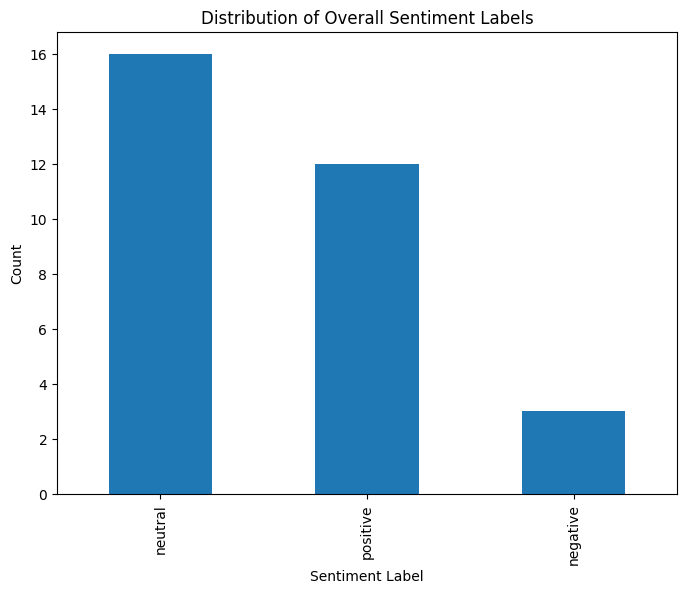

In [515]:
plt.figure(figsize=(8, 6))  
merged_df['overall_sentiment_label'].value_counts().plot(kind='bar')  
plt.title('Distribution of Overall Sentiment Labels')  
plt.xlabel('Sentiment Label')  
plt.ylabel('Count')  
plt.show()  


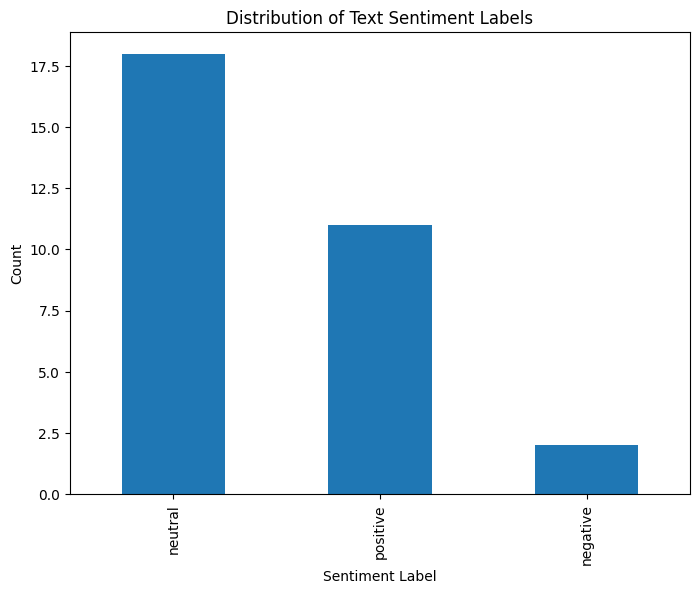

In [518]:
plt.figure(figsize=(8, 6))  
merged_df['text_sentiment_label'].value_counts().plot(kind='bar')  
plt.title('Distribution of Text Sentiment Labels')  
plt.xlabel('Sentiment Label')  
plt.ylabel('Count')  
plt.show()  


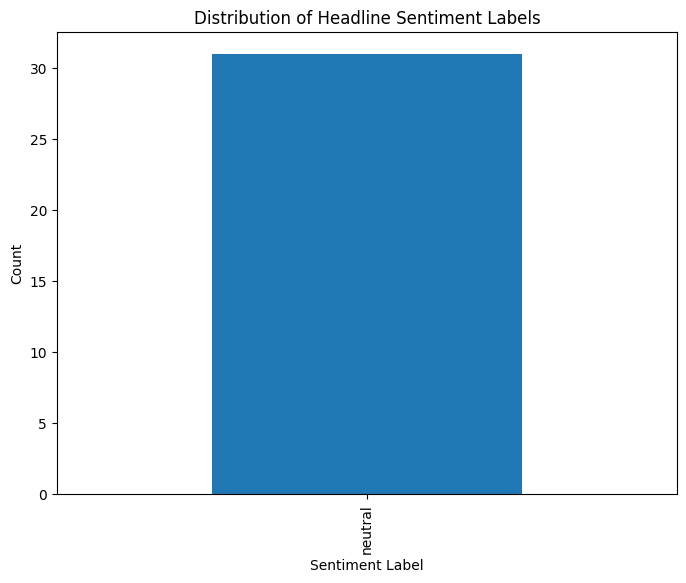

In [517]:
plt.figure(figsize=(8, 6))  
merged_df['headline_sentiment_label'].value_counts().plot(kind='bar')  
plt.title('Distribution of Headline Sentiment Labels')  
plt.xlabel('Sentiment Label')  
plt.ylabel('Count')  
plt.show()

In [519]:

df = merged_df  
  
 
le = LabelEncoder()  
df['overall_sentiment_label'] = le.fit_transform(df['overall_sentiment_label'])  
df['text_sentiment_label'] = le.fit_transform(df['text_sentiment_label'])  
df['headline_sentiment_label'] = le.fit_transform(df['headline_sentiment_label'])  
  
 
X = df[['text_sentiment_label', 'headline_sentiment_label']]  
y = df['overall_sentiment_label']  
  
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  
  
  
rf = RandomForestClassifier(n_estimators=100, random_state=42)  
rf.fit(X_train, y_train)  
  
  
y_pred = rf.predict(X_test)  
  

print("Accuracy:", accuracy_score(y_test, y_pred))  
print("Classification Report:\n", classification_report(y_test, y_pred))  
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.8571428571428571
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      0.75      0.86         4
           2       0.67      1.00      0.80         2

    accuracy                           0.86         7
   macro avg       0.89      0.92      0.89         7
weighted avg       0.90      0.86      0.86         7

Confusion Matrix:
 [[1 0 0]
 [0 3 1]
 [0 0 2]]
